In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv("Spring2024.csv")

weekdays = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 
            'Fri': 4, 'Sat': 5, 'Sun': 6} 

# Converting Weekdays into integer for easier handling
df['Days_number'] = df['Days'].apply(lambda txt: [] if pd.isna(txt) or txt == "To Be Announced"
                                     else [weekdays.get(item, item) for item in txt.split()])

def make_timetable(df):
    time_set = set()
    for index, row in df.iterrows():
        if not pd.isna(row['Dates']):
            class_start = pd.to_datetime(row['Dates'].split('-')[0]) 
            class_end = pd.to_datetime(row['Dates'].split('-')[1]) + pd.DateOffset(1)
            time_set.add(class_start)
            time_set.add(class_end)

    range = pd.date_range(min(time_set), max(time_set), freq='5min') # Find the longest timerange in the courses dataset
    cal_df = pd.DataFrame(range, columns=['Datetime']) # Make a df with the longest timerange
    # cal_df = cal_df[(cal_df['Datetime'].dt.weekday != 5) & (cal_df['Datetime'].dt.weekday != 6)]


    for index, row in df.iterrows(): # Loop through each row of the original df
        if pd.isna(row['Time']):
            continue
        
        cal_df[row['Class Nbr']] = 0 # Fill every class columns with 0 (Class not present)

        # Extract weekday, date, time as series from the df
        cor_weekday = cal_df['Datetime'].dt.weekday
        cor_date = cal_df['Datetime'].dt.date
        cor_time = cal_df['Datetime'].dt.time

        # Find the start date, end date, and class time of each course 
        class_start = pd.to_datetime(row['Dates'].split('-')[0]).date() 
        class_end = (pd.to_datetime(row['Dates'].split('-')[1]) + pd.DateOffset(1)).date()
        start_time = datetime.strptime(row['Time'].split('-')[0].strip(), "%I:%M %p").time()
        end_time = datetime.strptime(row['Time'].split('-')[1].strip(), "%I:%M %p").time()

        # Filter the df to find the exact time that class is present
        condition = ((cor_weekday.isin(row['Days_number'])) 
                     & (cor_date >= class_start) & (cor_date <= class_end) 
                     & (cor_time >= start_time) & (cor_time <= end_time))
        cal_df.loc[condition, row['Class Nbr']] = 1 # Set the period to 1 if class is present
    
    cal_df['Heat'] = cal_df.sum(axis=1, numeric_only=True) # Sum all the heat from each row
    
    return cal_df

timetable = make_timetable(df)
timetable

,Datetime,14121,19656,14122,14123,14124,14125,14126,14127,14128,...,18147,17509,19444,17512,17513,17514,17515,17516,19694,Heat
0,2024-01-08 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-08 00:05:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-08 00:10:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2024-01-08 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-08 00:20:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30236,2024-04-21 23:40:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30237,2024-04-21 23:45:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30238,2024-04-21 23:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30239,2024-04-21 23:55:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


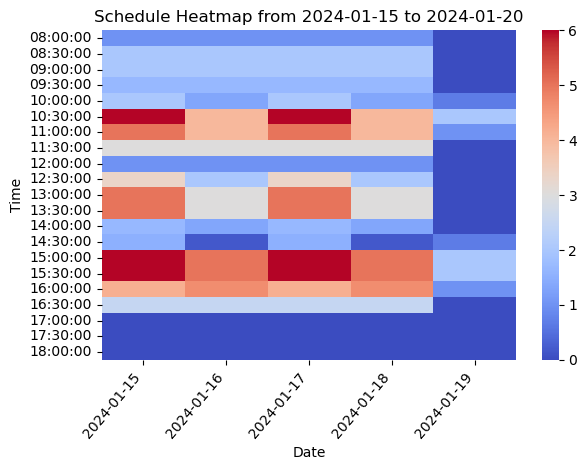

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

def timetable_heatmap(timetable, start_date=None, end_date=None, 
                      earliest_class="8:00 AM", latest_class="6:00 PM", period="30min"):
    if start_date: # Convert string in format YYYY-MM-DD to datetime
        start_date = pd.to_datetime(start_date)
    else: # If there's no start date given, take the first date in the df as start date
        start_date = timetable.loc[0, 'Datetime']
        
    if end_date: # Convert string in format YYYY-MM-DD to datetime
        end_date = pd.to_datetime(end_date)
    else: # If there's no end date given, set the end-date to 5 days past the start date (Mon => Fri)
        end_date = start_date + pd.DateOffset(5)

    # Convert string in format "H:MM II" to time
    earliest_class = datetime.strptime(earliest_class, "%I:%M %p").time()
    latest_class = datetime.strptime(latest_class, "%I:%M %p").time()

    # Make a table of dates between start and end and calculate average heat in a period
    weektable = timetable[(timetable['Datetime'] >= start_date) & (timetable['Datetime'] < end_date)]
    weektable = weektable[['Datetime', 'Heat']]
    weektable.set_index('Datetime', inplace=True)
    weektable = weektable.resample(period).mean()
    weektable.reset_index(inplace=True)

    # Create 2 columns of separate Date and Time
    weektable['Date'] = weektable['Datetime'].apply(lambda x: x.date())
    weektable['Time'] = weektable['Datetime'].apply(lambda x: x.time())
    weektable.drop('Datetime', axis=1, inplace=True)

    # Group table by date and time and filter for time between earliest and latest class
    weektable = weektable.groupby(['Date', 'Time']).sum()
    weektable = weektable.unstack(level='Date')
    weektable.columns = weektable.columns.droplevel()
    weektable = weektable[(weektable.index >= earliest_class) & (weektable.index <= latest_class)]

    # Plot heatmap
    plt.title(f'Schedule Heatmap from {start_date.date()} to {end_date.date()}')
    sns.heatmap(weektable, cmap='coolwarm')
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()
    return 
    
timetable_heatmap(timetable, '2024-01-15', '2024-01-20')